In [1]:
from time_series.ARIMA.TimeSeriesSimulatorARIMA import TimeSeriesSimulatorARIMA
from analysis.statistics import show_adfuller_analysis
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
from analysis.tools import lag_difference

from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

In [2]:
ts_simulator = TimeSeriesSimulatorARIMA()
ts_simulator.load_parameters(filename="parameters_set_1_arima.json",
                                 path="/home/louis/Documents/codes/ARIMA_Box_Jenkins_method/")

In [3]:
ts_simulator.generate_time_series()

In [84]:
time_serie = ts_simulator.components.observation_values

In [87]:
size = int(0.66 * len(time_serie))
X = time_serie
train, test = X[0:size], X[size:len(X)]

# 1 - Data analysis: Are the observation stationary ?

The first thing is to see of the data are stationary. We clearly have a upward trend here so the data are not stationary. We are thus going to make the data stationary. We use the augmented Dickey-Fuller test with a constant term but no trend. The null hypothesis is thus that the process  has a unit root and is not stationary. Small p-values indicate lows evidence of obtaining the statistc given the null hypothesis. Since our value obtained for the ADF statistics is bigger that the critical values, the null hypothesis can not be rejected and this indicate that the time serie is non-stationary. It can be seem visualy that we have an upward trend. 

In [7]:
show_adfuller_analysis(train)

ADF Statistic: -0.988323
p-value: 0.757500
Critical Values:
	1%: -3.522
	5%: -2.901
	10%: -2.588


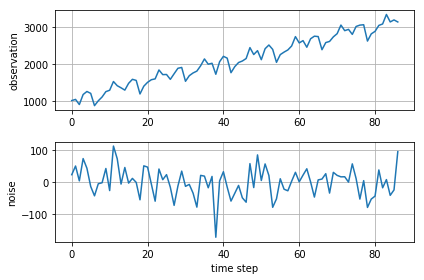

In [4]:
ts_simulator.components.show()

We now look at the autocorrelation and partial autocorrelation in the data. 

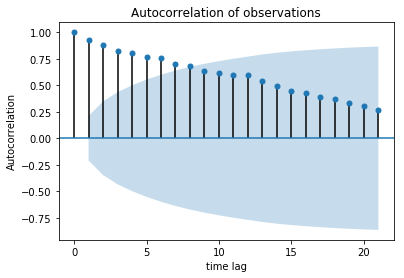

In [9]:
ax = plt.subplot(111)
plot_acf(train, lags=21, alpha=0.05, ax=ax)
ax.set_xlabel("time lag")
ax.set_ylabel("Autocorrelation")
ax.set_title("Autocorrelation of observations")
plt.show()

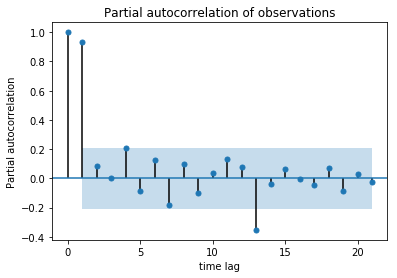

In [10]:
ax = plt.subplot(111)
plot_pacf(train, lags=21, alpha=0.05, ax=ax)
ax.set_xlabel("time lag")
ax.set_ylabel("Partial autocorrelation")
ax.set_title("Partial autocorrelation of observations")
plt.show()

# 1.1 Analysis of observations

From forecasting, "no significant autocorrelations after lag q, a MA(q) model may be appropriate. If there are no significant partial autocorrelations after lag p, an AR(p) model may be appropriate". We will first try to achieved stationarity. We have two value with high partial autocorrelation at lag 1 and 13, since 13 is not interpretable (this is monthly data), we will first remove the trend with the difference. 

In [26]:
difference =lag_difference(train, lag=11)

In [27]:
show_adfuller_analysis(difference)

ADF Statistic: -1.636314
p-value: 0.464188
Critical Values:
	1%: -3.539
	5%: -2.909
	10%: -2.592


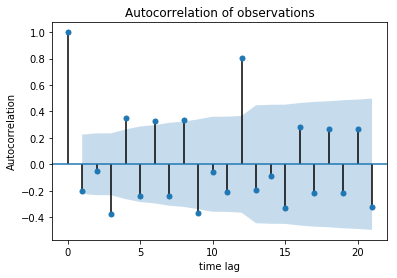

In [30]:
ax = plt.subplot(111)
plot_acf(difference, lags=21, alpha=0.05, ax=ax)
ax.set_xlabel("time lag")
ax.set_ylabel("Autocorrelation")
ax.set_title("Autocorrelation of observations")
plt.show()

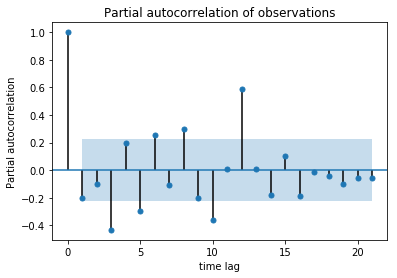

In [31]:
ax = plt.subplot(111)
plot_pacf(difference, lags=21, alpha=0.05, ax=ax)
ax.set_xlabel("time lag")
ax.set_ylabel("Partial autocorrelation")
ax.set_title("Partial autocorrelation of observations")
plt.show()

# 1.2 Analysis of difference

Looking at the results of the first difference, we have have removed part of the trend and the data are closer to beeing stationary. We now have a high correlation at lag 12 which is what we expected from monthly data. We will now apply the seasonal difference at lag 12.

In [34]:
difference_seasonal  = lag_difference(difference, lag=12)

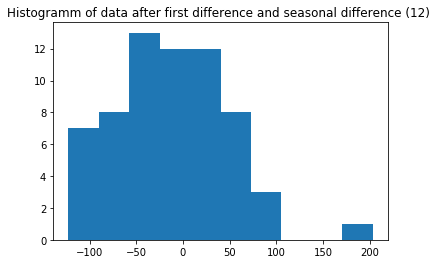

In [49]:
plt.title("Histogramm of data after first difference and seasonal difference (12) ")
plt.hist(difference_seasonal)
plt.show()

In [40]:
show_adfuller_analysis(difference_seasonal)

ADF Statistic: -2.070306
p-value: 0.256621
Critical Values:
	1%: -3.546
	5%: -2.912
	10%: -2.594


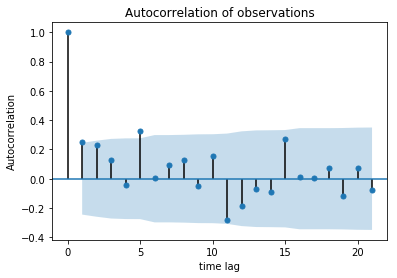

In [41]:
ax = plt.subplot(111)
plot_acf(difference_seasonal, lags=21, alpha=0.05, ax=ax)
ax.set_xlabel("time lag")
ax.set_ylabel("Autocorrelation")
ax.set_title("Autocorrelation of observations")
plt.show()

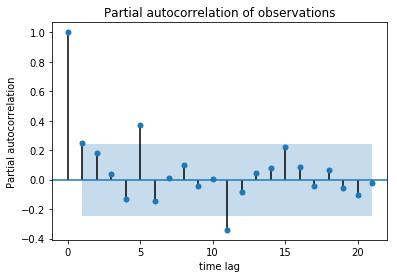

In [43]:
ax = plt.subplot(111)
plot_pacf(difference_seasonal, lags=21, alpha=0.05, ax=ax)
ax.set_xlabel("time lag")
ax.set_ylabel("Partial autocorrelation")
ax.set_title("Partial autocorrelation of observations")
plt.show()

# 1.3 Analysis of seasonal difference with first difference

Most of the correlation in the data have been removed from the first difference and the seasonal difference. We will thus try to model the observation with a seasonal model and a first difference.  

# 2 - Modeling

In [ ]:
model = SARIMAX(time_serie, order=(0,1,1), seasonal_order=(0,1,1,12))
model_fit = model.fit(disp=0)
print(model_fit.summary())

In [44]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# 3 - Estimation of model parameters

In [53]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [82]:
p_order_possible_values = [0,1,2,3]
q_order_possible_values = [0,1,2,4]

In [104]:
p_order_optimal = -1
q_order_optimal = -1
best_bayesian_information_criteria = -1

In [106]:
for p_order in p_order_possible_values:
    for q_order in q_order_possible_values:
        
        P_order = 0
        Q_order = 1
        
        
        model = SARIMAX(train, 
                        order=(p_order,1,q_order),
                        seasonal_order=(P_order,1,Q_order,12),
                       enforce_invertibility=False)
        model_fit = model.fit()
        
        if model_fit.bic > best_bayesian_information_criteria:
            best_bayesian_information_criteria = model_fit.bic
            p_order_optimal = p_order
            q_order_optimal = q_order


/home/louis/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/louis/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/louis/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/louis/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/louis/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to c

Best parameters (1,1,1)(0,1,1)
Bayesian information criteria: 1963.71


/home/louis/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [101]:
print("Best parameters (%d,1,%d)(%d,1,%d)" % (p_order_optimal,q_order_optimal,P_order, Q_order))
print("Bayesian information criteria: %.2f" % best_bayesian_information_criteria)

# 4 - Forecasting 

In [125]:
history = [x for x in train]
predictions = list()

for t in range(len(test)):
    
    model = SARIMAX(history, 
                    order=(p_order_optimal,1,q_order_optimal),
                    seasonal_order=(0,1,1,12),
                    enforce_invertibility=False)

    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

/home/louis/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/louis/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/louis/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/louis/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/louis/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to c

Test MSE: 2503.640


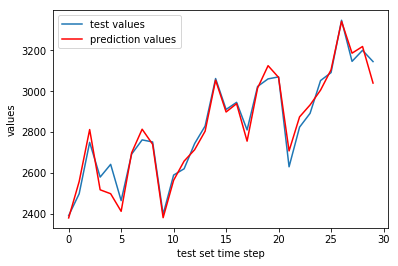

In [127]:
ax = plt.subplot(111)
ax.set_xlabel("test set time step")
ax.set_ylabel("values")
plt.plot(test, label="test values")
plt.plot(predictions, label="prediction values", color='red')
plt.legend()
plt.show()

# 5 - Forecasting  analysis

In [ ]:
acorr_ljungbox(difference, lags=20)